In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
print(os.listdir("../input"))
%matplotlib inline

['game_skater_stats.csv', 'game_goalie_stats.csv', 'game_teams_stats.csv', 'table_relationships.JPG', 'game.csv', 'team_info.csv', 'game_plays_players.csv', 'game_shifts.csv', 'game_plays.csv', 'player_info.csv']


In [2]:
team_df = pd.read_csv('../input/team_info.csv')

In [3]:
team_df.head()

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6


In [4]:
#game_df.head()

In [5]:
"""
Add home and away team names.
"""
game_df = pd.read_csv('../input/game.csv')
game_df = game_df.merge(team_df[['team_id', 'teamName']],
              left_on='home_team_id', right_on='team_id') \
    .merge(team_df[['team_id', 'teamName']], left_on='away_team_id',
           right_on='team_id', suffixes=('home','away'))

In [6]:
game_df.head()

,game_id,season,type,date_time,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_idhome,teamNamehome,team_idaway,teamNameaway
0,2012030221,20122013,P,2013-05-16,3,6,2,3,home win OT,left,TD Garden,/api/v1/venues/null,America/New_York,-4,EDT,6,Bruins,3,Rangers
1,2012030222,20122013,P,2013-05-19,3,6,2,5,home win REG,left,TD Garden,/api/v1/venues/null,America/New_York,-4,EDT,6,Bruins,3,Rangers
2,2012030225,20122013,P,2013-05-25,3,6,1,3,home win REG,left,TD Garden,/api/v1/venues/null,America/New_York,-4,EDT,6,Bruins,3,Rangers
3,2013020380,20132014,R,2013-11-29,3,6,2,3,home win REG,left,TD Garden,/api/v1/venues/null,America/New_York,-4,EDT,6,Bruins,3,Rangers
4,2012020179,20122013,R,2013-02-13,3,6,4,3,away win SO,left,TD Garden,/api/v1/venues/null,America/New_York,-4,EDT,6,Bruins,3,Rangers


# Distribution of Goals
The distribution of home goals had a higher mean than away goals. "Home ice advantage?"

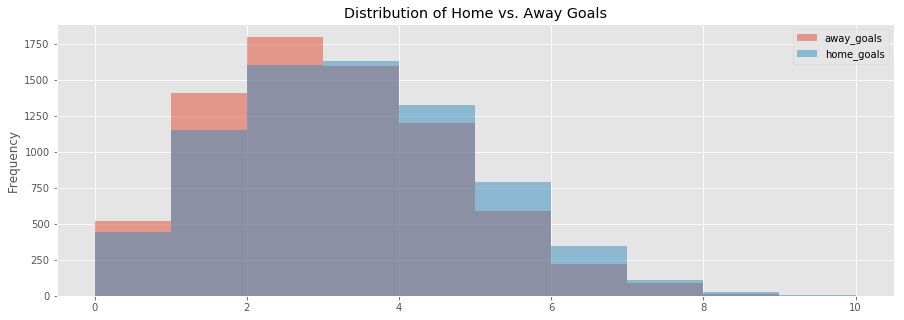

In [7]:
game_df[['away_goals','home_goals']].plot(kind='hist', figsize=(15,5), bins=10, alpha=0.5, title='Distribution of Home vs. Away Goals')

# Average Goals per Team


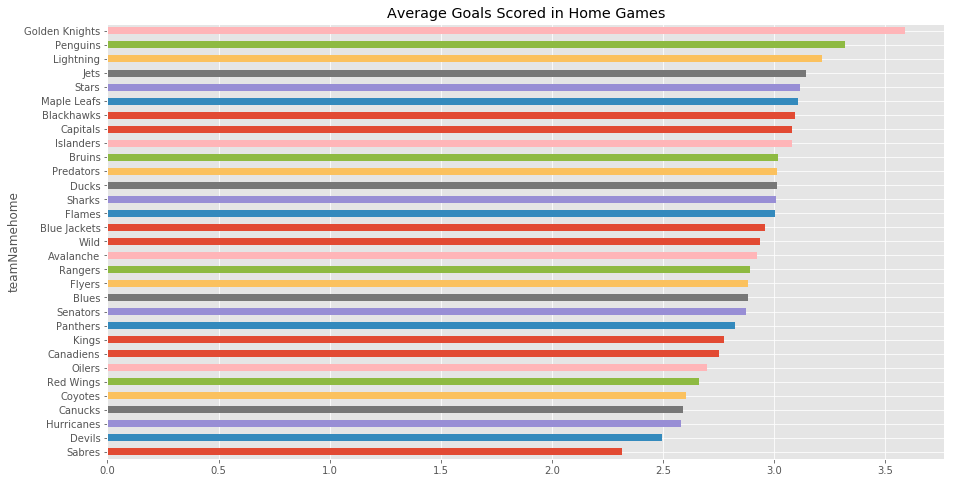

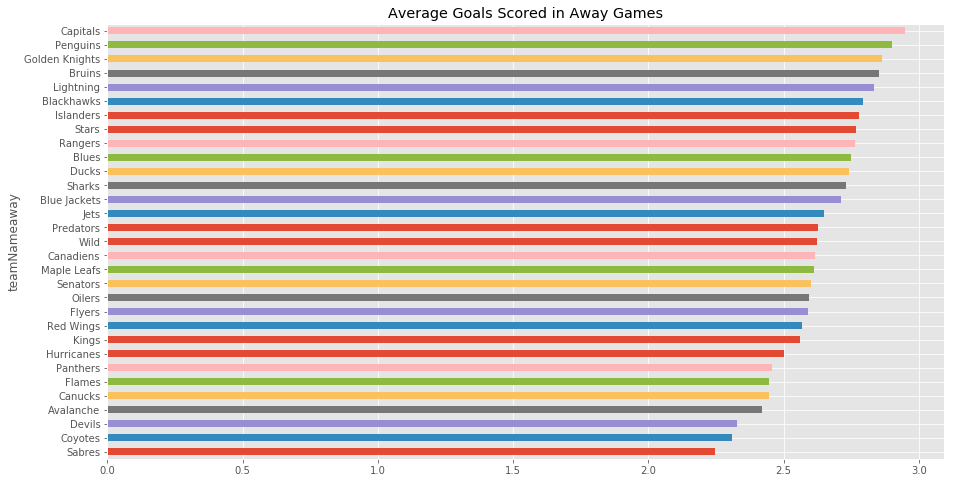

In [8]:
game_df.groupby('teamNamehome').mean()['home_goals'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), title='Average Goals Scored in Home Games')
plt.show()
game_df.groupby('teamNameaway').mean()['away_goals'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), title='Average Goals Scored in Away Games')
plt.show()

# Average Goals Allowed per Team

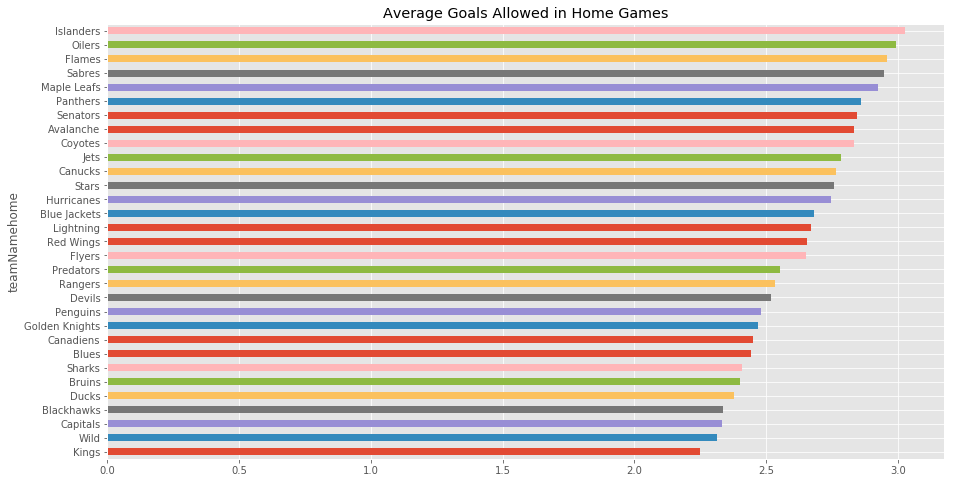

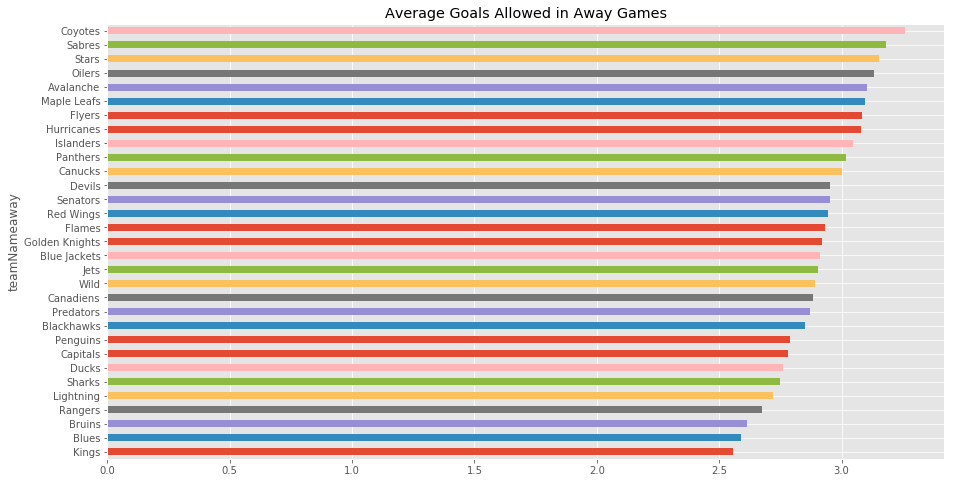

In [9]:
game_df.groupby('teamNamehome').mean()['away_goals'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), title='Average Goals Allowed in Home Games')
plt.show()
game_df.groupby('teamNameaway').mean()['home_goals'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), title='Average Goals Allowed in Away Games')
plt.show()

# Distribution of Point Differential

How much do teams usually win/lose by? Point differential is computed as:
`point_diff` = `home team goals` - `away team goals`

In [10]:
game_df['point_diff'] = game_df['home_goals'] - game_df['away_goals']

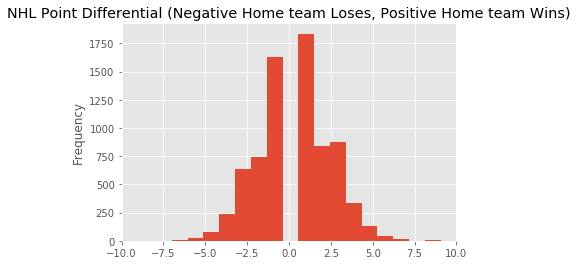

In [11]:
game_df['point_diff'].plot(kind='hist',
                           bins=18,
                           title='NHL Point Differential (Negative Home team Loses, Positive Home team Wins)',
                           xlim=(-10,10))

# Biggest Blowout

In [12]:
#Biggest Blowout was by 10 points
game_df['point_diff'].abs().max()

10

In [13]:
# Blowout game:
game_df.loc[game_df['point_diff'] == 10]

,game_id,season,type,date_time,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_idhome,teamNamehome,team_idaway,teamNameaway,point_diff
3860,2016020158,20162017,R,2016-11-04,8,29,0,10,home win REG,left,Nationwide Arena,/api/v1/venues/null,America/New_York,-4,EDT,29,Blue Jackets,8,Canadiens,10


Ouch that was a blowout. 
Here are the video highlights in case you were wondering how it happened: https://www.nhl.com/bluejackets/video/recap-mtl-0-cbj-10/t-283041746/c-46026003

Lets define game types as:
- Blowout (abs point diff >= 3 points)
- Normal Game (win > 2 points)
- Tight Game (win by 1 point)

In [14]:
game_df['point_diff_type'] = game_df['point_diff'].abs().apply(lambda x: 'Blowout' if x>=3 else ('Normal' if x>=2 else 'Tight'))

In [15]:
# Create one dataframe with the point 
point_diff_team = pd.concat([game_df[['teamNamehome','point_diff_type','point_diff','date_time']].rename(columns={'teamNamehome':'team'}),
    game_df[['teamNameaway','point_diff_type','point_diff','date_time']].rename(columns={'teamNameaway':'team'})])

In [16]:
point_diff_team['date_time'] = pd.to_datetime(point_diff_team['date_time'])

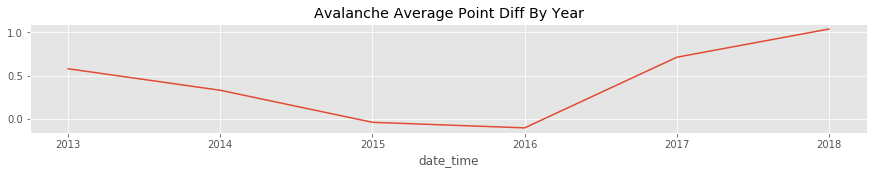

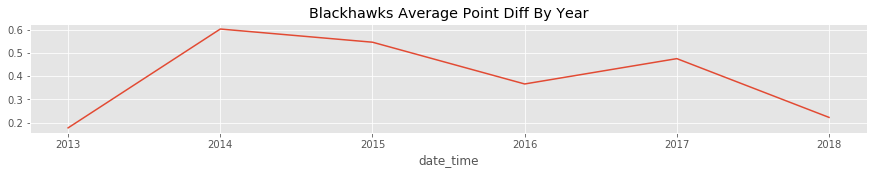

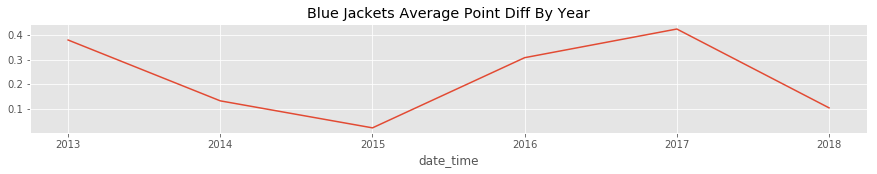

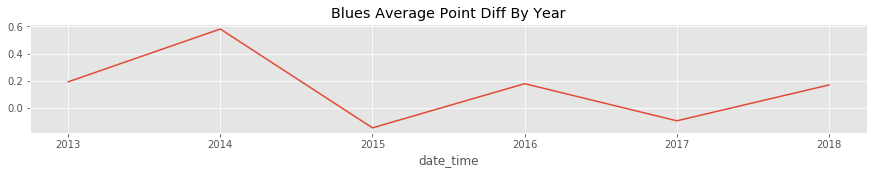

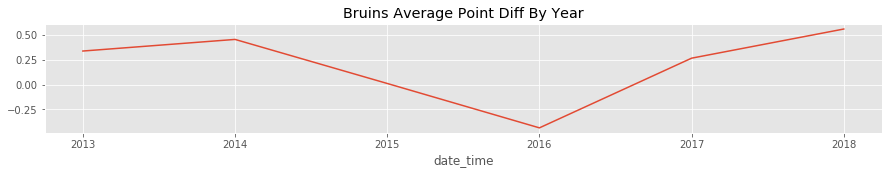

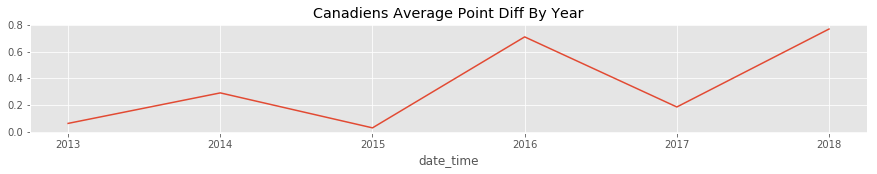

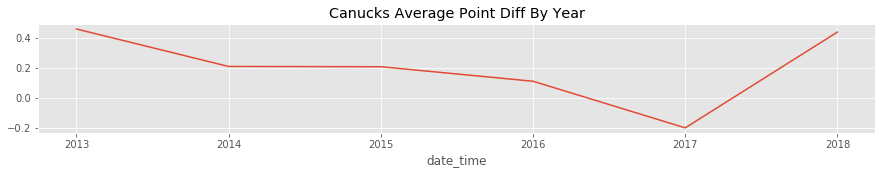

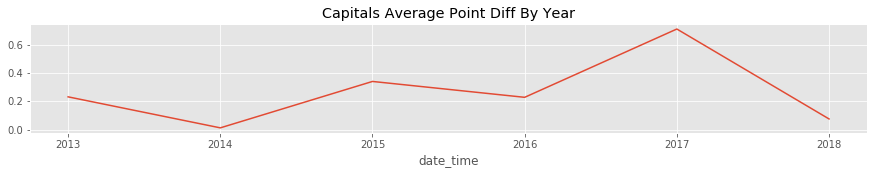

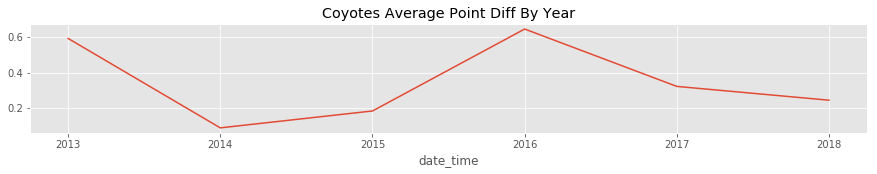

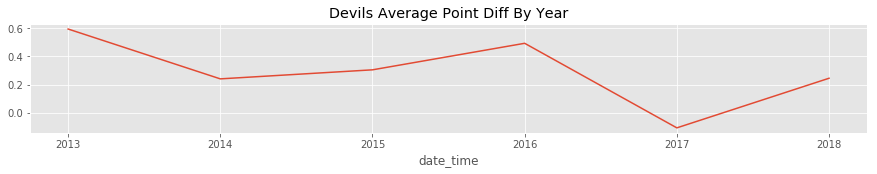

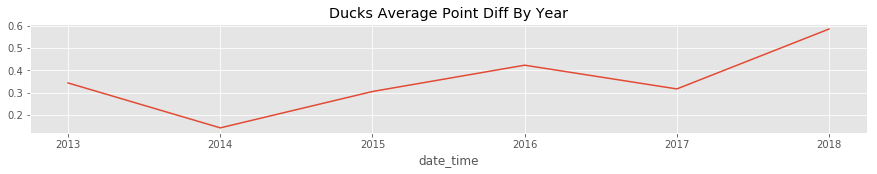

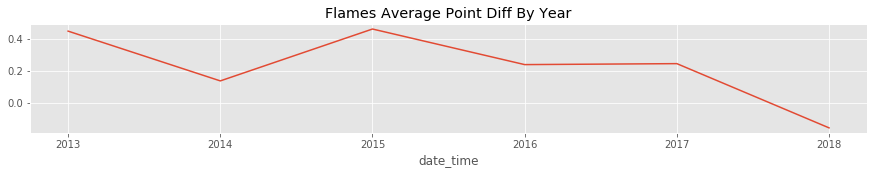

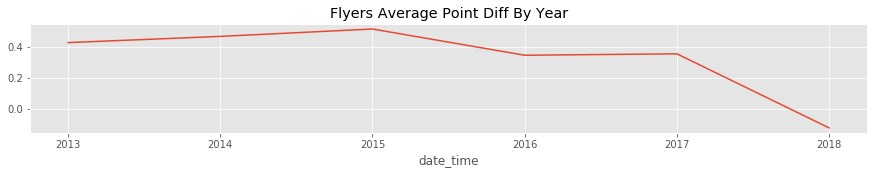

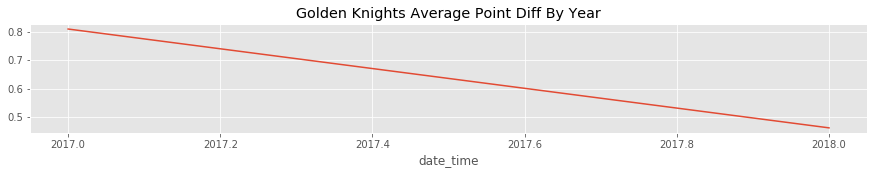

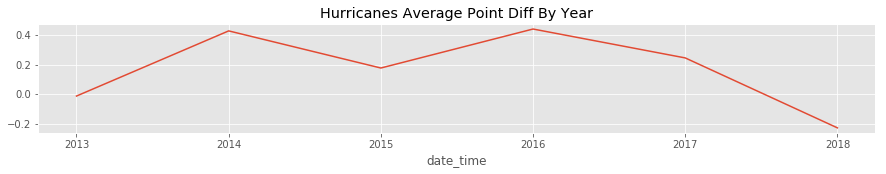

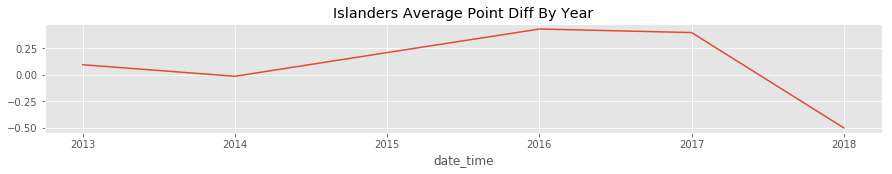

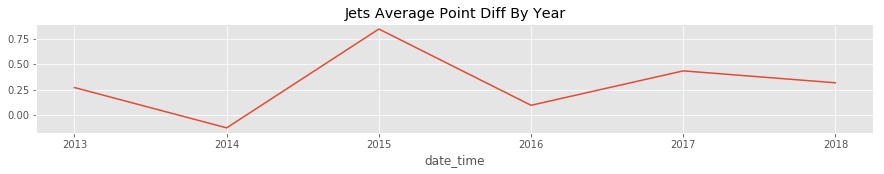

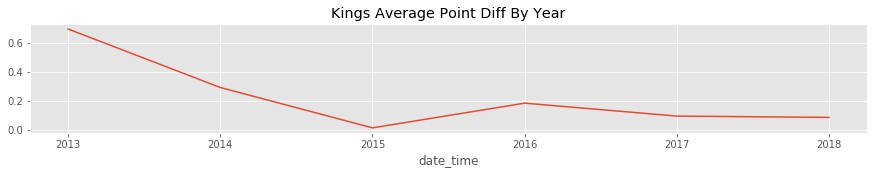

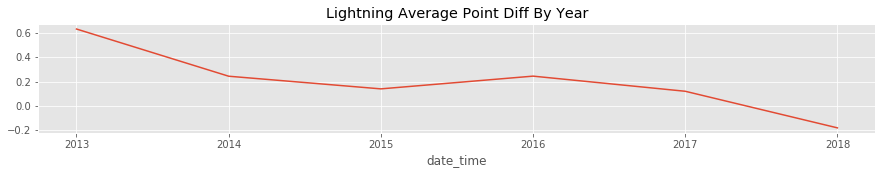

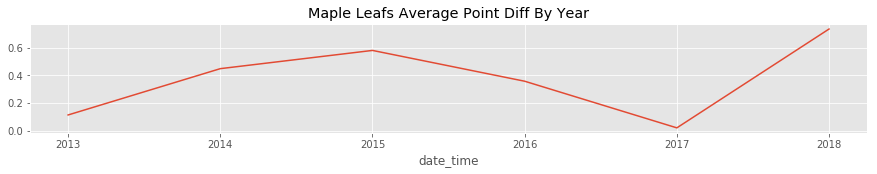

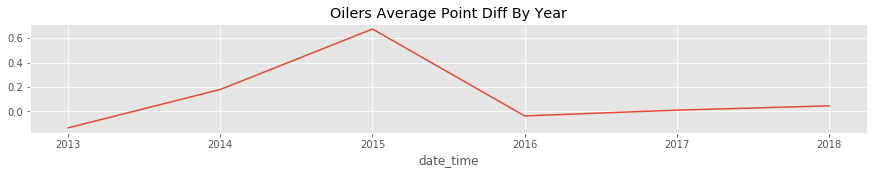

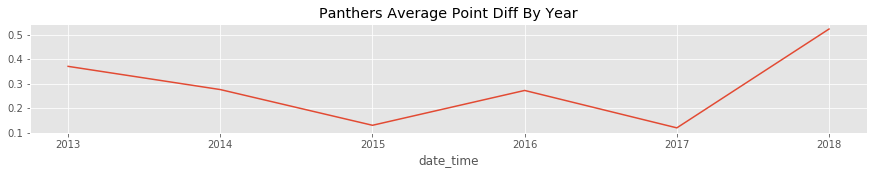

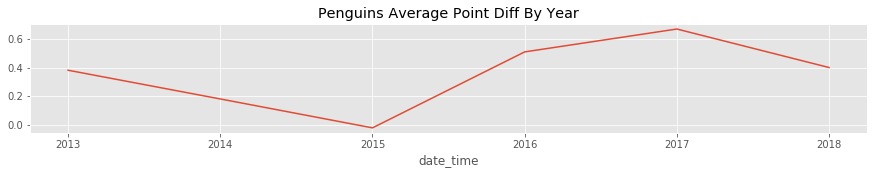

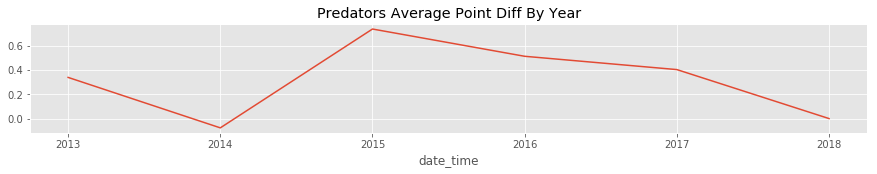

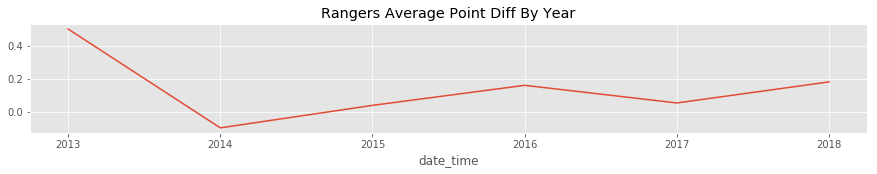

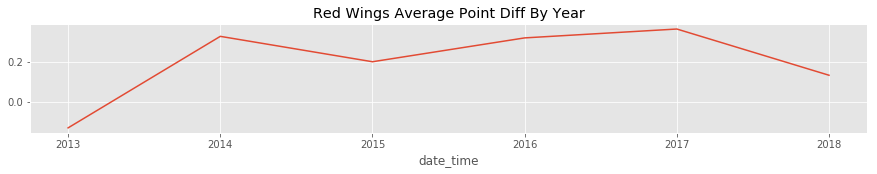

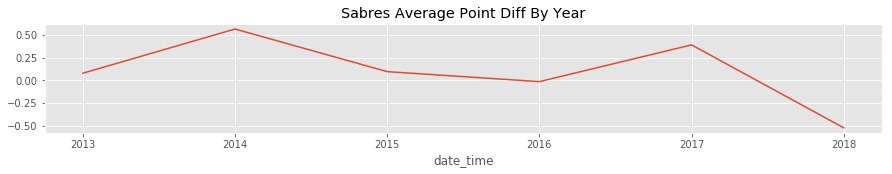

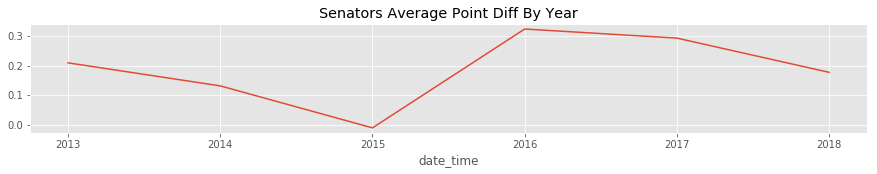

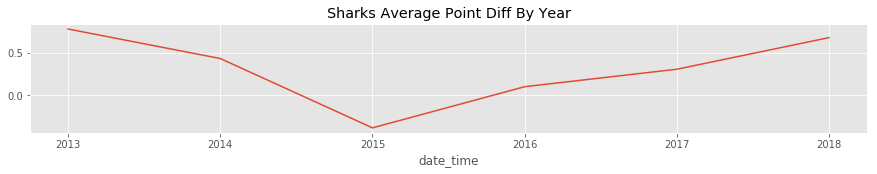

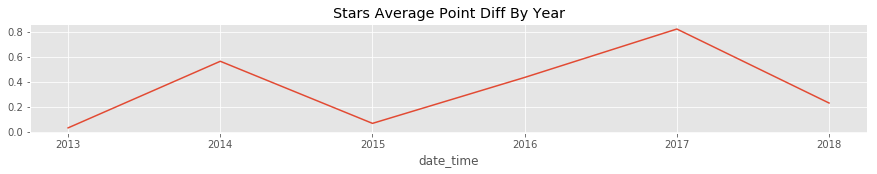

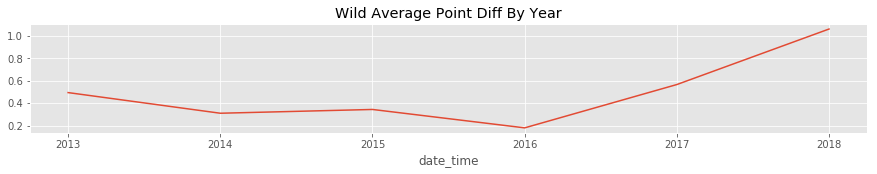

In [17]:
for team, data in point_diff_team.groupby('team'):
    data.groupby(data['date_time'].dt.year).mean()['point_diff'].plot(kind='line', title='{} Average Point Diff By Year'.format(team), figsize=(15,2))
    plt.show()

# TODO
- Better metrics
- Figure out how to make plot colors = team colors
- More fun stuff

GO WINGS!

# K Nearest Neighbors

In [18]:
team_stats_df = pd.read_csv('../input/game_teams_stats.csv')

In [19]:
team_stats_df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2012030221,3,away,False,OT,John Tortorella,2,35,44,8,3,0,44.8,17,7
1,2012030221,6,home,True,OT,Claude Julien,3,48,51,6,4,1,55.2,4,5
2,2012030222,3,away,False,REG,John Tortorella,2,37,33,11,5,0,51.7,1,4
3,2012030222,6,home,True,REG,Claude Julien,5,32,36,19,1,0,48.3,16,6
4,2012030223,6,away,True,REG,Claude Julien,2,34,28,6,0,0,61.8,10,7


In [20]:
team_stats_df.describe()

,game_id,team_id,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
count,1.488200e+04,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000
mean,2.014705e+09,17.634995,2.720400,30.301102,23.822134,9.919298,3.127873,0.588160,50.000000,8.593872,6.732630
std,1.633558e+06,12.254780,1.620288,6.815795,8.831214,7.655860,1.526146,0.750102,7.173525,4.804905,3.748612
min,2.012020e+09,1.000000,0.000000,10.000000,2.000000,0.000000,0.000000,0.000000,20.800000,0.000000,0.000000
25%,2.013021e+09,8.000000,2.000000,26.000000,18.000000,6.000000,2.000000,0.000000,45.125000,5.000000,4.000000
50%,2.015020e+09,16.000000,3.000000,30.000000,23.000000,8.000000,3.000000,0.000000,50.000000,8.000000,6.000000
75%,2.016021e+09,24.000000,4.000000,35.000000,29.000000,12.000000,4.000000,1.000000,54.875000,11.000000,9.000000
max,2.017030e+09,54.000000,10.000000,64.000000,80.000000,129.000000,11.000000,6.000000,79.200000,36.000000,31.000000


In [21]:
team_stats_df.columns

Index(['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways'],
      dtype='object')

In [22]:
team_stats_df.corr()

,game_id,team_id,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
game_id,1.000000,0.059407,0.000000,0.048646,0.091313,-0.112334,-0.113629,-0.064320,0.006385,0.000000,0.112651,0.059264
team_id,0.059407,1.000000,-0.003422,-0.000277,-0.016943,-0.011797,0.001876,0.001041,-0.010930,0.013690,-0.031993,-0.016959
won,0.000000,-0.003422,1.000000,0.596168,0.011387,-0.066085,-0.039524,0.023468,0.222618,0.029157,-0.006853,0.109725
goals,0.048646,-0.000277,0.596168,1.000000,0.131058,-0.085346,0.031145,0.102210,0.436044,0.031957,0.013630,0.110820
shots,0.091313,-0.016943,0.011387,0.131058,1.000000,0.018839,-0.039702,0.176987,0.082958,0.143581,0.053231,0.101240
hits,-0.112334,-0.011797,-0.066085,-0.085346,0.018839,1.000000,0.051252,-0.071362,-0.032808,-0.005751,0.148766,0.029662
pim,-0.113629,0.001876,-0.039524,0.031145,-0.039702,0.051252,1.000000,0.212606,0.095632,-0.012769,-0.056464,-0.060972
powerPlayOpportunities,-0.064320,0.001041,0.023468,0.102210,0.176987,-0.071362,0.212606,1.000000,0.394226,0.040548,0.015156,-0.031541
powerPlayGoals,0.006385,-0.010930,0.222618,0.436044,0.082958,-0.032808,0.095632,0.394226,1.000000,0.014504,0.003521,0.024240
faceOffWinPercentage,0.000000,0.013690,0.029157,0.031957,0.143581,-0.005751,-0.012769,0.040548,0.014504,1.000000,0.054981,0.049372


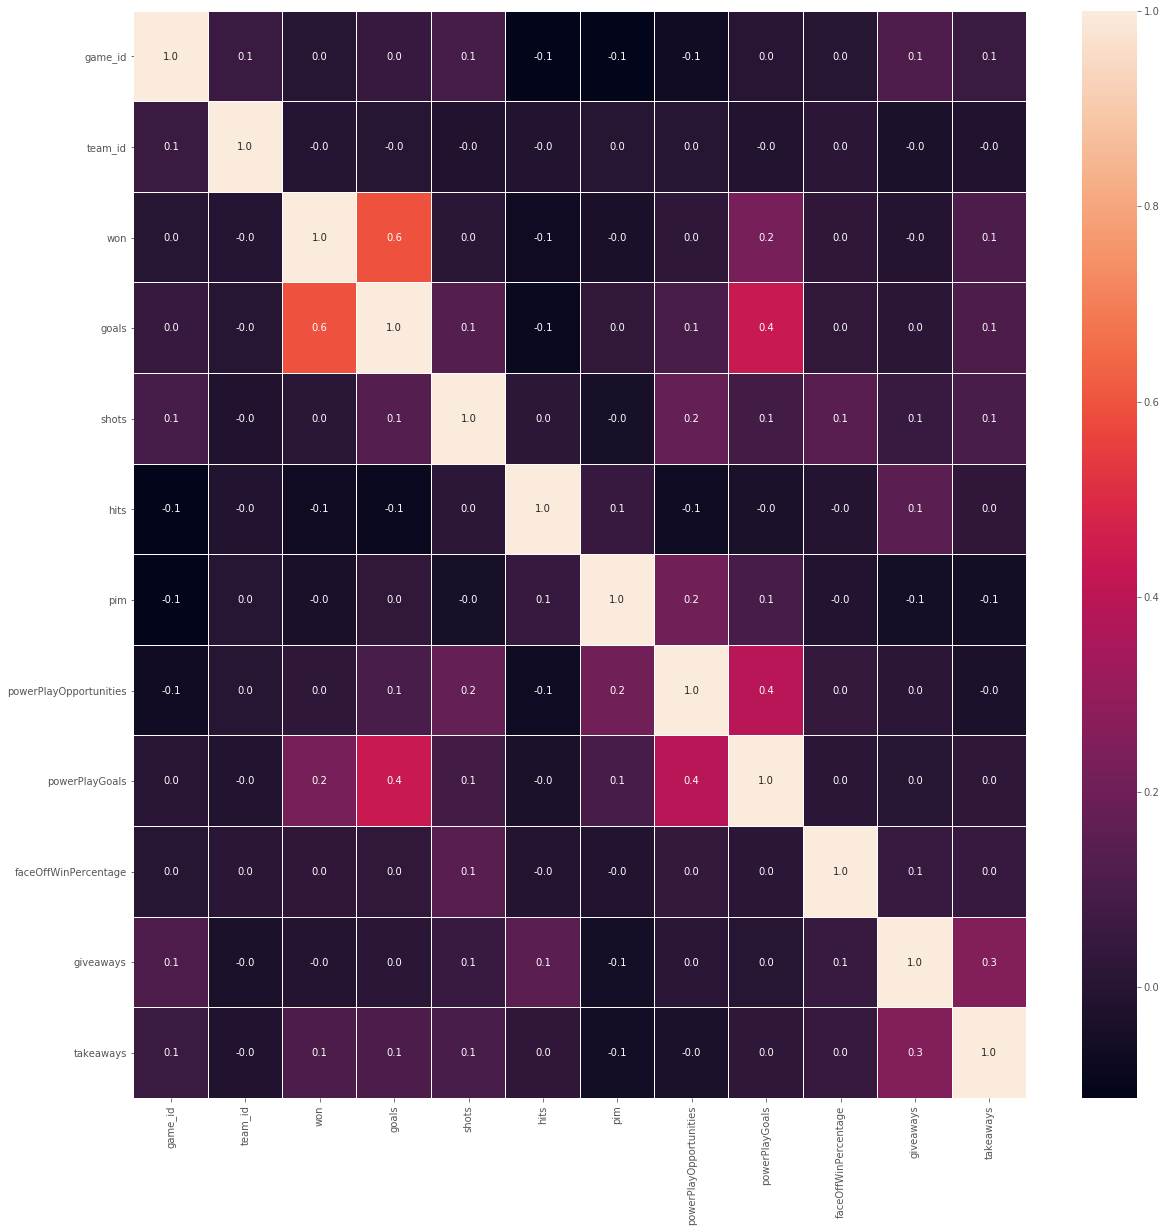

In [23]:
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(team_stats_df.corr(), annot = True,linewidths=.2, fmt='.1f', ax=ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


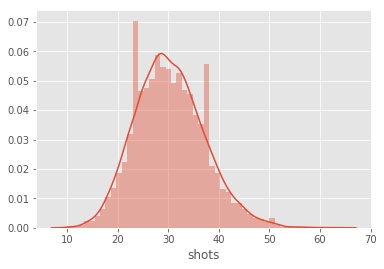

In [24]:
sns.distplot(team_stats_df['shots'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


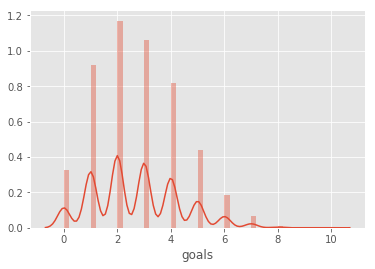

In [25]:
sns.distplot(team_stats_df['goals'])

In [26]:
#make the 'won' column data binary
team_stats_df['won'] = team_stats_df['won']*1

team_stats_df = pd.concat([team_stats_df, pd.get_dummies(team_stats_df.HoA).rename(columns = '{}_binary'.format)],axis = 1)
team_stats_df = pd.concat([team_stats_df, pd.get_dummies(team_stats_df.settled_in).rename(columns = '{}_binary'.format)],axis = 1)
df_clean = team_stats_df.drop(['game_id','team_id','HoA','settled_in','head_coach','away_binary','OT_binary','SO_binary'], axis=1)
df_clean.head()

,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,home_binary,REG_binary
0,0,2,35,44,8,3,0,44.8,17,7,0,0
1,1,3,48,51,6,4,1,55.2,4,5,1,0
2,0,2,37,33,11,5,0,51.7,1,4,0,1
3,1,5,32,36,19,1,0,48.3,16,6,1,1
4,1,2,34,28,6,0,0,61.8,10,7,0,1


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


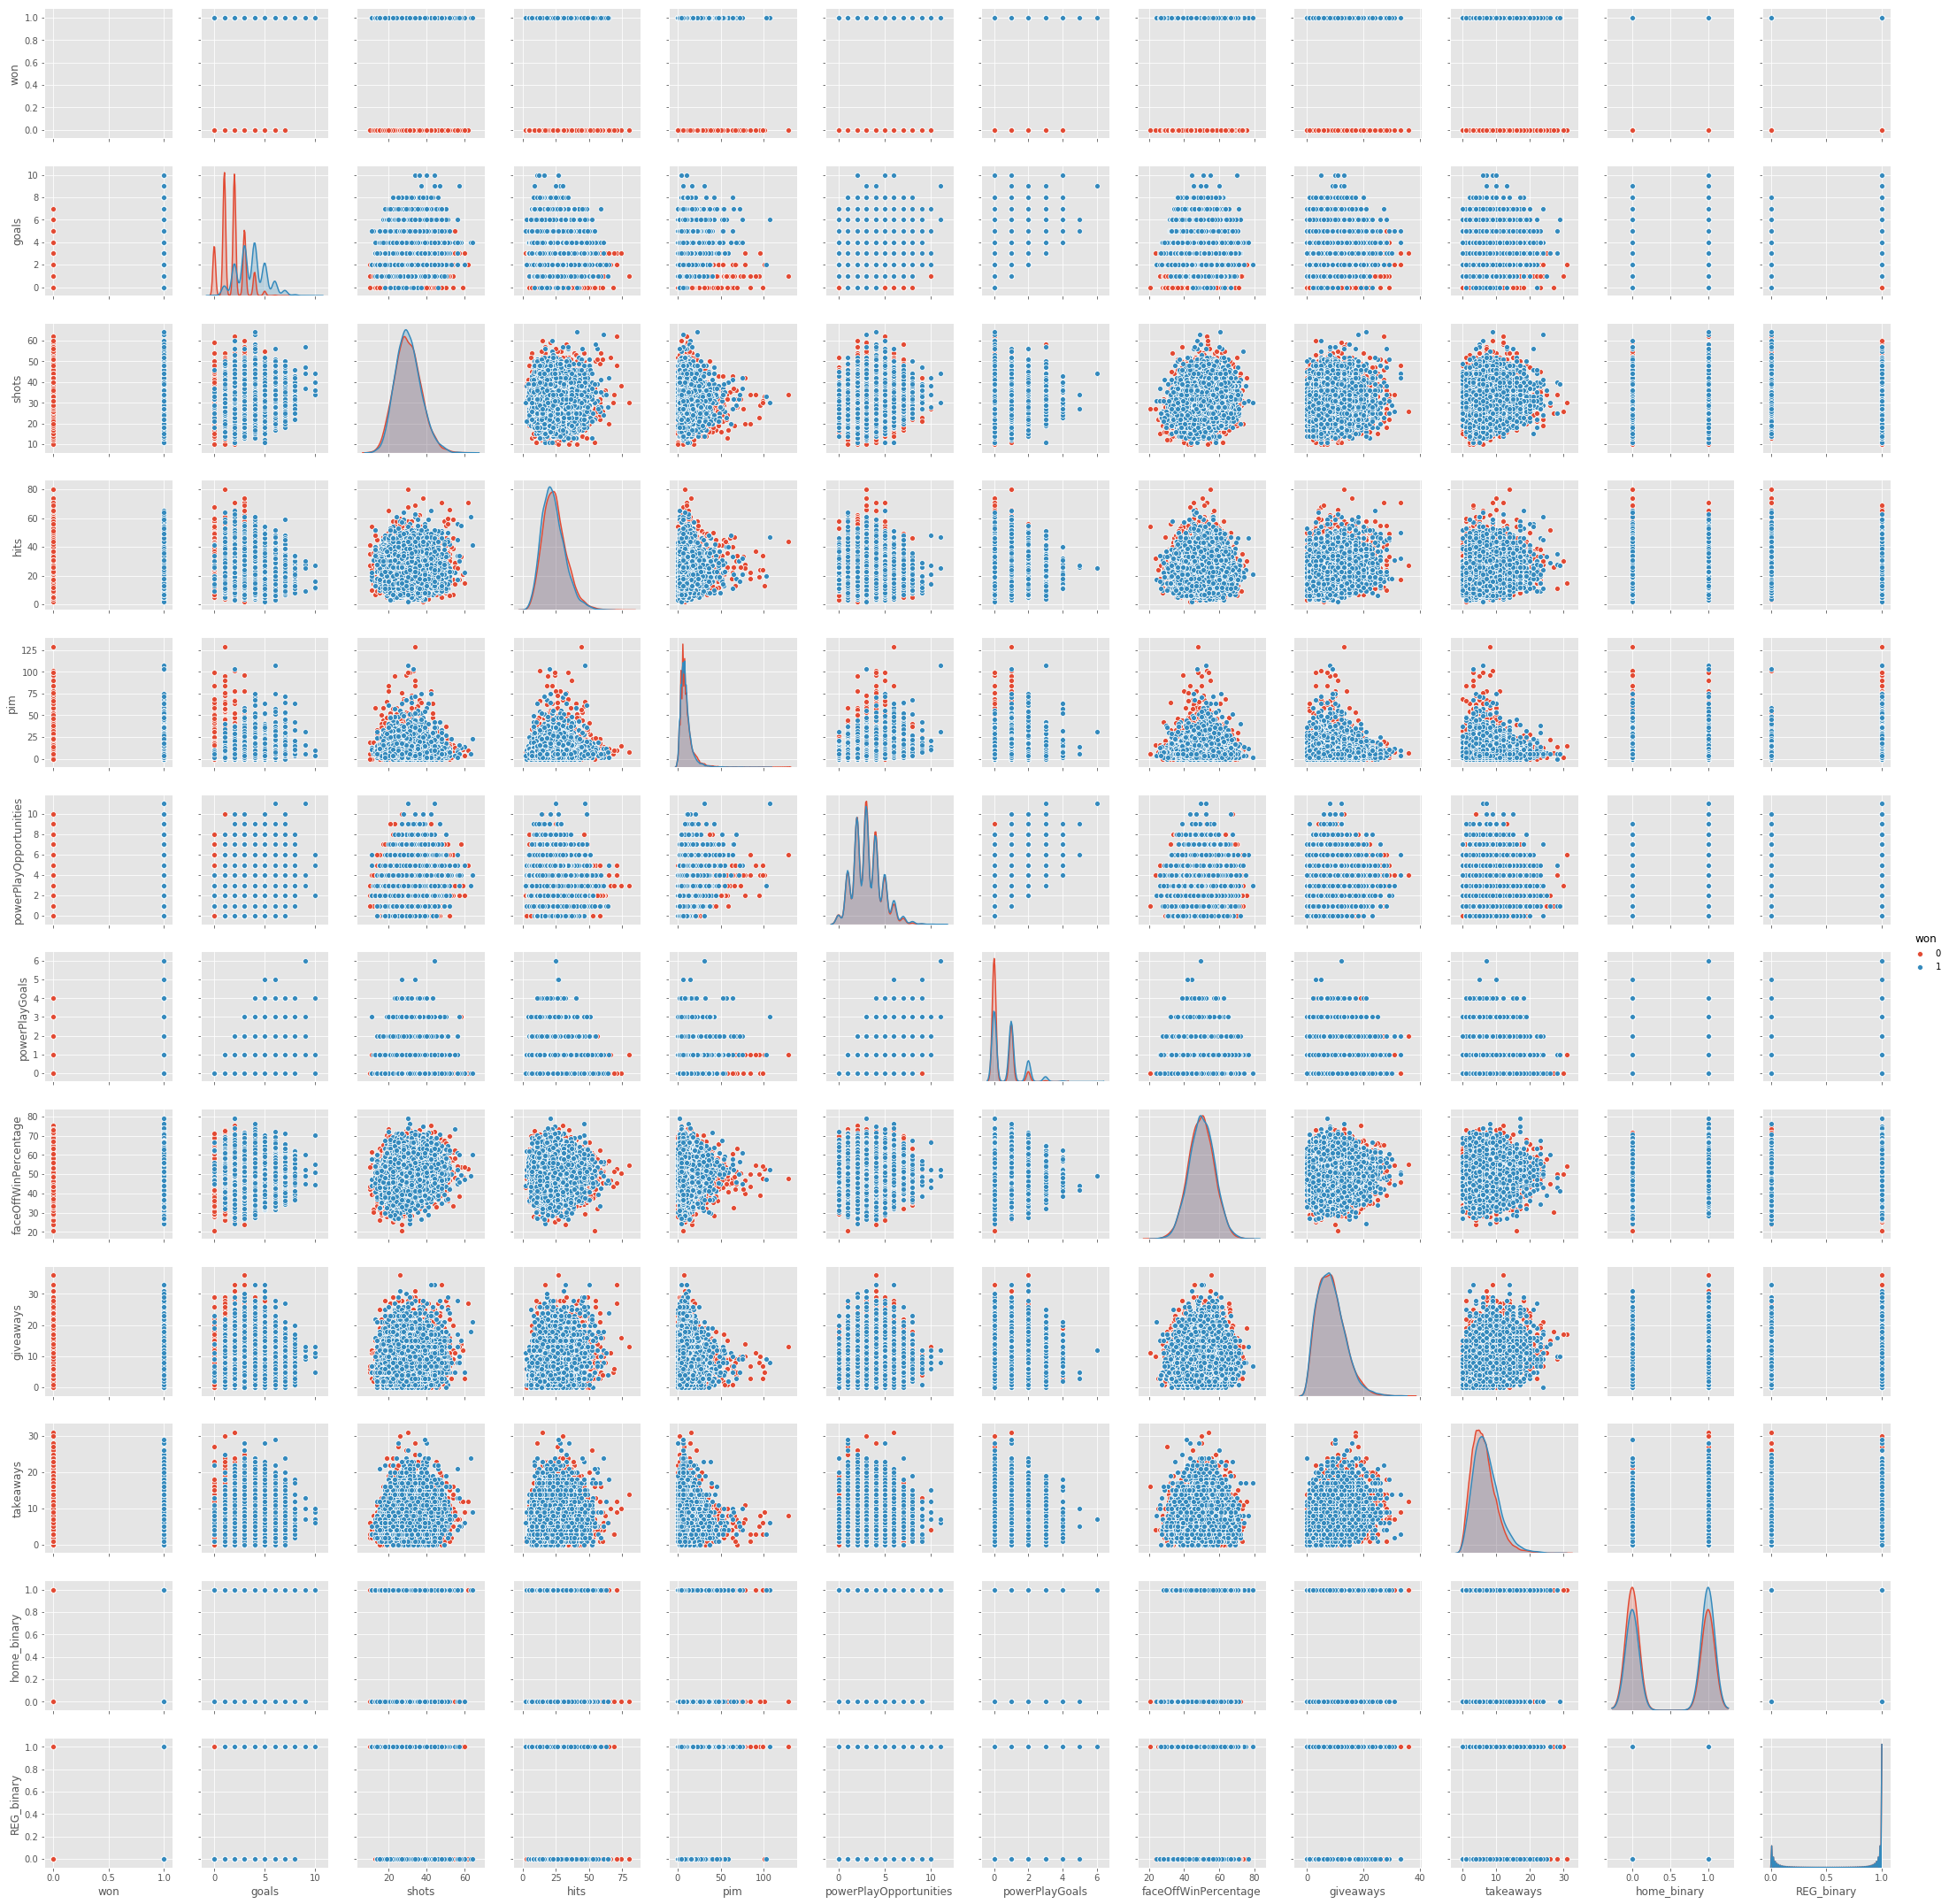

In [27]:
sns.pairplot(df_clean, hue='won')

# Standardize the Variables

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
scaler.fit(df_clean.drop('won',axis=1))
scaled_features = scaler.transform(df_clean.drop('won',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df_clean.columns[1:])
df_feat.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,home_binary,REG_binary
0,-0.444628,0.689436,2.284912,-0.250705,-0.083791,-0.784134,-0.724912,1.749548,0.071327,-1.0,-1.793949
1,0.172567,2.596835,3.077581,-0.511952,0.571477,0.549064,0.724912,-0.956112,-0.462221,1.0,-1.793949
2,-0.444628,0.982882,1.039288,0.141165,1.226744,-0.784134,0.236990,-1.580495,-0.728996,-1.0,0.557429
3,1.406957,0.249267,1.379004,1.186151,-1.394325,-0.784134,-0.236990,1.541420,-0.195447,1.0,0.557429
4,-0.444628,0.542713,0.473095,-0.511952,-2.049593,-0.784134,1.644993,0.292654,0.071327,-1.0,0.557429


# Train Test Split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = df_feat
y = df_clean['won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Using KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
knn = KNeighborsClassifier(n_neighbors=1)

In [34]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

# Predictions and Evaluations

In [35]:
pred = knn.predict(X_test)

In [36]:
from sklearn.metrics import classification_report,confusion_matrix

In [37]:
print(confusion_matrix(y_test,pred))

[[1527  729]
 [ 729 1480]]


In [38]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2256
           1       0.67      0.67      0.67      2209

   micro avg       0.67      0.67      0.67      4465
   macro avg       0.67      0.67      0.67      4465
weighted avg       0.67      0.67      0.67      4465



# Choosing a K Value

In [39]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0,0.5,'Error Rate')

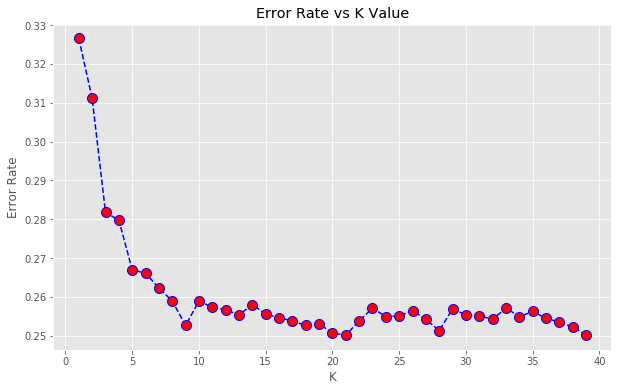

In [40]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# K = 20

In [42]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[1817  439]
 [ 680 1529]]


              precision    recall  f1-score   support

           0       0.73      0.81      0.76      2256
           1       0.78      0.69      0.73      2209

   micro avg       0.75      0.75      0.75      4465
   macro avg       0.75      0.75      0.75      4465
weighted avg       0.75      0.75      0.75      4465

